In [4]:
import datetime as dt
import pandas as pd

import nltk
import re
import requests
import string

from bs4 import BeautifulSoup, Comment, NavigableString, SoupStrainer
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

In [5]:
class IndeedScraper:
    """ Class meant for scraping Indeed.com for specified job keywords and job locations"""

    def query_generator(self, keyword, location):
        """A function that takes a search keyword (or keywords) and a city and returns the resulting query url"""

        string1 = f"https://www.indeed.com/jobs?as_and={keyword}&as_phr=&as_any=&as_not=&as_ttl=&as_cmp=&jt=all&st=&"
        string2 = f"sr=directhire&as_src=&salary=&radius=50&l={location}&fromage=any&sort=&psf=advsrch"
        query = string1 + string2

        return query

    def search_results_numeric(self, query):
        '''A function that takes a search query url and returns the number of search results'''

        search_count = SoupStrainer(id="searchCount")
        page = requests.get(query)
        soup = BeautifulSoup(page.text, "html.parser", parse_only=search_count)
        s = soup.get_text()
        num_search_results = [int(item) for item in s.split(' ') if item.isdigit()][-1]
        result = "Number of job results:" + str(num_search_results)
        return num_search_results


    def search_page_generator(self, query, num_search_results, limit=50):
        '''A function that takes a query url and the number of search results corresponding that query, 
        and returns a list of urls to be scraped.'''

        urls_to_scrape = []
        converted_search_results = int(num_search_results)
        i = int(converted_search_results / 50)
        
        for page_number in range(i + 1):
            
            url_suffix = f'&limit={limit}&start={str(page_number * 50)}'
            url = f'{query}{url_suffix}'
            urls_to_scrape.append(url)
            
        return urls_to_scrape

    def make_soup(self, query, parser='html.parser'):

        '''A function that takes a query url and returns a BeautifulSoup object. html.parser is passed in as default parser'''

        page = requests.get(query)
        soup = BeautifulSoup(page.text, parser)

        return soup
    

    # Map iterables in urls_to_scrape into soup_generator()
    def extract_job_postings(self, url_list):
        """A function that takes a list of urls from search_page_generator() 
         and returns a list of BeautifulSoup objects corresponding to each job posting in the list of urls"""
    
        job_postings = []
        
        for url in url_list:
            
            soup = scraper.make_soup(url)
            for result in soup.find_all('div', attrs={'data-tn-component': 'organicJob'}):
                job_postings.append(result)
            
        return job_postings
    
    def process_job_posting(self, job):
        """
        Function that parses through html elements of indeed job postings and prints them in a prettified string output
        """
        
        # job id
        
        
        try:
            job_id = job.find('h2', attrs={"class": "jobtitle"})['id']
            #print("Job ID:", job_id)
        except AttributeError:
            job_id = 'NA'
        

        # job title
        try:
            job_title = job.find('a', attrs={'data-tn-element':"jobTitle"}).text.strip().capitalize()
        except AttributeError:
            job_title = 'NA'
        #print("Job Title:", job_title)

        # * company
        try:
            company = job.find('span', class_='company').text.strip()
        except AttributeError:
            company = 'NA'
        #print("Company:", company)

        # location
        try:
            location = job.find('span', class_='location').get_text()
        except AttributeError:
            location = 'NA'
        #print("Location:", location)
        
        # date_posting
        try:
            post_date = job.find('span', class_='date').get_text()
        except AttributeError:
            post_date = 'NA'
        #print("Date Posted:", post_date)
        
        
        # salary_range

        try:
            salary = job.find('span', class_='salary no-wrap').text.strip()
            #print("Salary:" , salary)
        except AttributeError:
            salary = 'NA'

        # job_summary

        summary = job.find('span', class_='summary').text.strip()
        #print("Job Summary:", summary)

        # job_link

        job_link = "https://www.indeed.com" + job.find('h2', attrs={"class": "jobtitle"}).find('a')['href']
        #print("Job_link:", job_link)
        
        # full description
        
        request = requests.get(job_link)
        request_soup = BeautifulSoup(request.text, "html.parser")
        description = request_soup.find('div', attrs={"class": "jobsearch-JobComponent-description"})
        description = description.text.strip()
        
        #print(description)
        return [job_id, job_title, company, location, post_date, salary, summary, job_link, description]

In [6]:

# =========================== EXAMPLE USAGE ==============================================
# init class object
scraper = IndeedScraper()
# define query with keyword/keywords and location
test_query = scraper.query_generator('tensorflow', "21044")
# store the amount of search results
num_search_results = scraper.search_results_numeric(test_query)
# create urls from query and associated number of jobs
urls = scraper.search_page_generator(test_query, num_search_results)

# you can skip this step, it's built into IndeedScraper.extract_job_postings(), just testing functionality
#soup = scraper.make_soup(test_query) 

# this opens all the links from the pages and stores their full text description for later use
job_postings = scraper.extract_job_postings(urls)

#============================================== debug ==============================================
#print(test_query)
print(num_search_results)
#print(urls)
#print(soup)
#print(len(job_postings))
#============================================== debug ==============================================

# verifying all is working
test = scraper.process_job_posting(job_postings[0])
print(test)

235
['jl_562d33167e34080f', 'Research scientist ii', 'Parsons', 'Aberdeen, MD', '30+ days ago', 'NA', 'Experience with machine learning, such as the Tensorflow framework, a plus. < h1 style="FONT-FAMILY:....', 'https://www.indeed.com/rc/clk?jk=562d33167e34080f&fccid=e8f998ddd15bac9c&vjs=3', '< h1 style="FONT-FAMILY: Arial; WHITE-SPACE: normal; WORD-SPACING: 0px; TEXT-TRANSFORM: none; COLOR: rgb(0,0,0); FONT-STYLE: normal; ORPHANS: 2; WIDOWS: 2; LETTER-SPACING: normal; BACKGROUND-COLOR: rgb(255,255,255); TEXT-INDENT: 0px; font-variant-ligatures: normal; font-variant-caps: normal; -webkit-text-stroke-width: 0px; text-decoration-style: initial; text-decoration-color: initial" align="center">Research Scientist II\nAberdeen Proving Ground, MD\n\nAre you an experienced Researcher who thrives in a fast-paced environment working with teams in a support role? Imagine yourself working on top level critical network defense missions alongside other seasoned professionals. Parsons is now hiring top

## 2) Use NLTK to tokenize / clean the listings 

In [7]:
columns = ['ID', 'Title', 'Company', 'Location', 'Date', 'Salary', 'Summary', 'Link', 'FullText']
dataframe = pd.DataFrame(columns=columns)

In [8]:
for job_number in range(0, num_search_results - 1):
    dataframe.loc[len(dataframe)] = (scraper.process_job_posting(job_postings[job_number]))

TypeError: 'NoneType' object is not subscriptable

In [9]:
dataframe = dataframe.applymap(str)
dataframe.head()

,ID,Title,Company,Location,Date,Salary,Summary,Link,FullText
0,jl_562d33167e34080f,Research scientist ii,Parsons,"Aberdeen, MD",30+ days ago,NA,"Experience with machine learning, such as the ...",https://www.indeed.com/rc/clk?jk=562d33167e340...,"< h1 style=""FONT-FAMILY: Arial; WHITE-SPACE: n..."
1,jl_a276ea2539679009,Yolo developer,K&M Systems,"Tysons Corner, VA",2 days ago,NA,"Job Description K&M Systems, Inc. is looking f...",https://www.indeed.com/rc/clk?jk=a276ea2539679...,"ContractJob Description\nK&M Systems, Inc. is ..."
2,jl_d250438a9ddba27f,Summer intern - robotics group,Intelligent Automation,"Rockville, MD 20855",30+ days ago,NA,Summer Intern -Robotics Group The Robotics and...,https://www.indeed.com/rc/clk?jk=d250438a9ddba...,"Temporary, InternshipSummer Intern -Robotics G..."
3,jl_52ad992137a033cf,Intern - artificial intelligence,Alion Science and Technology,"Annapolis Junction, MD 20701",30+ days ago,NA,Experience with deep learning frameworks and l...,https://www.indeed.com/rc/clk?jk=52ad992137a03...,"Part-time, Temporary, InternshipResponsibiliti..."
4,jl_bf5e7b9c2fa68d9c,Machine learning (ml) researcher,Johns Hopkins Applied Physics Laboratory (APL),"Laurel, MD 20708",9 hours ago,NA,"Keras, TensorFlow, CAFFE 2; Would you like to ...",https://www.indeed.com/rc/clk?jk=bf5e7b9c2fa68...,Introduction:\nWould you like to be a part of ...


In [10]:
df_copy = dataframe.copy()
df_copy['FullText'] = df_copy['FullText'].str.replace('[^A-Za-z\s]+', ' ')
df_copy['FullText'] = df_copy['FullText'].str.replace('\n', ' ')

In [11]:
# pull job desc to series
words = df_copy['FullText']
print("Descriptions to move to string:" ,len(words))

print("\nExample description:\n", words[0])

Descriptions to move to string: 100

Example description:
   h  style FONT FAMILY  Arial  WHITE SPACE  normal  WORD SPACING   px  TEXT TRANSFORM  none  COLOR  rgb  FONT STYLE  normal  ORPHANS    WIDOWS    LETTER SPACING  normal  BACKGROUND COLOR  rgb  TEXT INDENT   px  font variant ligatures  normal  font variant caps  normal   webkit text stroke width   px  text decoration style  initial  text decoration color  initial  align center Research Scientist II Aberdeen Proving Ground  MD  Are you an experienced Researcher who thrives in a fast paced environment working with teams in a support role  Imagine yourself working on top level critical network defense missions alongside other seasoned professionals  Parsons is now hiring top Research Scientists with a passion for innovation and solving mission critical challenges   Parsons  extensive experience in this field  combined with your technical knowledge  will propel your career forward  Training  mentorship and the opportunity for advanc

In [12]:
# series to string
words = words.astype(str)
words = ''.join(words)

In [13]:
print(len(words))

372094


In [15]:
nltk.download('averaged_perceptron_tagger')
word_tokens = nltk.pos_tag(word_tokenize(words))
print("Sum of words with valid parts of speech tags:", len(word_tokens))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ksmith/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Sum of words with valid parts of speech tags: 53410


In [17]:

# code from https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def wordnet_part_of_speech(word):
    """Map POS tag to first character lemmatize() accepts"""
    
    # access list index, tuple index, map value
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
pos_parsed_words = [lemmatizer.lemmatize(w, wordnet_part_of_speech(w)) for w in nltk.word_tokenize(words)]
pos_parsed_words = [word for word in pos_parsed_words if word.isalpha()]

[nltk_data] Downloading package wordnet to /Users/ksmith/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
stop_words = set(stopwords.words('english'))
pos_parsed_words = [word for word in pos_parsed_words if word not in stop_words]
pos_parsed_words = [word.upper() for word in pos_parsed_words]

In [21]:
print("Words post parts of speech processing:", len(pos_parsed_words))

Words post parts of speech processing: 37129


In [22]:
fdist = FreqDist(pos_parsed_words)
fdist.most_common(30)

[('DATA', 657),
 ('EXPERIENCE', 566),
 ('LEARN', 434),
 ('WORK', 391),
 ('MACHINE', 331),
 ('SCIENCE', 258),
 ('TEAM', 256),
 ('DEVELOPMENT', 244),
 ('USE', 223),
 ('SOFTWARE', 209),
 ('RESEARCH', 205),
 ('WE', 205),
 ('INCLUDE', 191),
 ('SOLUTION', 188),
 ('MODEL', 180),
 ('DEVELOP', 171),
 ('YEAR', 162),
 ('TECHNOLOGY', 161),
 ('DEEP', 159),
 ('BUSINESS', 156),
 ('SKILL', 153),
 ('OPPORTUNITY', 149),
 ('COMPUTER', 149),
 ('PROCESSING', 148),
 ('THE', 140),
 ('ENGINEERING', 139),
 ('ALGORITHM', 139),
 ('TECHNICAL', 138),
 ('ABILITY', 135),
 ('KNOWLEDGE', 131)]

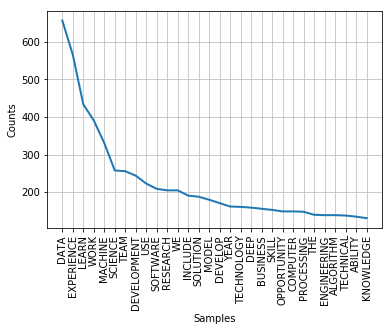

In [23]:
fdist.plot(30, cumulative=False)
plt.show()

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [24]:
vectorizer = CountVectorizer(max_features=None, ngram_range=(1,1), stop_words='english')

vectorizer.fit(pos_parsed_words)
print(vectorizer.vocabulary_)

{'style': 3211, 'font': 1339, 'family': 1277, 'arial': 232, 'white': 3585, 'space': 3109, 'normal': 2214, 'word': 3605, 'spacing': 3111, 'px': 2646, 'text': 3315, 'transform': 3381, 'color': 598, 'rgb': 2865, 'orphans': 2321, 'widows': 3593, 'letter': 1881, 'background': 323, 'indent': 1639, 'variant': 3507, 'ligature': 1898, 'cap': 449, 'webkit': 3571, 'stroke': 3203, 'width': 3594, 'decoration': 865, 'initial': 1665, 'align': 129, 'center': 484, 'research': 2816, 'scientist': 2946, 'ii': 1598, 'aberdeen': 1, 'proving': 2624, 'ground': 1478, 'md': 2020, 'experienced': 1231, 'researcher': 2817, 'thrives': 3336, 'fast': 1282, 'pace': 2343, 'environment': 1149, 'work': 3606, 'team': 3276, 'support': 3241, 'role': 2888, 'imagine': 1603, 'level': 1882, 'critical': 800, 'network': 2185, 'defense': 871, 'mission': 2086, 'alongside': 136, 'season': 2966, 'professional': 2573, 'parsons': 2363, 'hire': 1544, 'scientists': 2947, 'passion': 2375, 'innovation': 1671, 'solve': 3099, 'challenge': 49

In [25]:
vector_word_counts = vectorizer.transform(pos_parsed_words)

pos_vectorized = pd.DataFrame(vector_word_counts.toarray(), columns=vectorizer.get_feature_names())

In [26]:
pos_vectorized.shape

(37129, 3645)

In [27]:
pos_vectorized.head()

,aap,aberdeen,abet,abilities,ability,able,abreast,abroad,abstract,abundant,...,yearthe,yes,yeschild,yesmust,yolo,yr,zaktaccardi,zeppelin,zone,zookeeper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

In [0]:
##### Your Code Here #####

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [0]:
##### Your Code Here #####

## Stretch Goals

 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.